In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import geopandas as gpd
import streamlit as st

In [2]:
df = pd.read_csv("Otodom_Flat_Listings.csv")

In [3]:
df.head()

,Title,Price,Location,Surface,Number_of_Rooms,Floor,Finishing_Condition,Heating,Parking_Space,Balcony_Garden_Terrace,Link,Voivodeship,City
0,2 pokoje 47m2 po remoncie + garderoba + balkon,415000.0,"ul. Marysińska, Stare Bałuty, Bałuty, Łódź, łó...",47.0,2,NaN,do zamieszkania,miejskie,garaż/miejsce parkingowe,balkon,https://www.otodom.pl/pl/oferta/2-pokoje-47m2-...,Łódzkie,Łódź
1,Właściciel- Ludwiki DD - WIDOK NA ZIELEŃ - 2x gar,2499000.0,"ul. Ludwiki, Czyste, Wola, Warszawa, mazowieckie",105.0,4,2/8,do wykończenia,miejskie,garaż/miejsce parkingowe,balkon,https://www.otodom.pl/pl/oferta/wlasciciel-lud...,Mazowieckie,Warszawa
2,"Sprzedam mieszkanie 60m2, 2 balkony, garderoba",649000.0,"ul. Londyńska, Gorzów Wielkopolski, lubuskie",60.0,3,4/4,do zamieszkania,miejskie,NaN,"balkon, taras",https://www.otodom.pl/pl/oferta/sprzedam-miesz...,Lubuskie,Gorzów Wielkopolski
3,"Wyjątkowy, duży apartament z antresolą",2108000.0,"Mrzeżyno, Trzebiatów, gryficki, zachodniopomor...",78.3,3,4/4,do wykończenia,NaN,garaż/miejsce parkingowe,NaN,https://www.otodom.pl/pl/oferta/wyjatkowy-duzy...,Zachodniopomorskie,gryficki
4,"2/3-pok. 49,2 m2 w samym sercu Koszalina - Kuncer",450180.0,"ul. Bartosza Głowackiego, Koszalin, zachodniop...",49.2,2,2/3,do zamieszkania,miejskie,garaż/miejsce parkingowe,balkon,https://www.otodom.pl/pl/oferta/2-3-pok-49-2-m...,Zachodniopomorskie,Koszalin


In [4]:
df.dtypes

Title                      object
Price                     float64
Location                   object
Surface                   float64
Number_of_Rooms            object
Floor                      object
Finishing_Condition        object
Heating                    object
Parking_Space              object
Balcony_Garden_Terrace     object
Link                       object
Voivodeship                object
City                       object
dtype: object

In [5]:
print("{} rows \n{} columns".format(df.shape[0], df.shape[1]))

2807 rows 
13 columns


In [6]:
missing_values = df.isnull().sum()
missing_values

Title                        0
Price                      143
Location                     1
Surface                      0
Number_of_Rooms              0
Floor                       64
Finishing_Condition        578
Heating                    747
Parking_Space             1329
Balcony_Garden_Terrace     705
Link                         0
Voivodeship                  1
City                         1
dtype: int64

In [7]:
df['Price_per_m2'] = (df['Price'] / df['Surface']).round(2)

In [8]:
fig = px.scatter(df, x='Surface', y='Price', title='Outliers in Surface and Price',
                 labels={'Surface': 'Surface (m²)', 'Price': 'Price (PLN)'},
                 hover_data=['Price_per_m2'],
                 width=1200,
                 height=500)

fig.show()

In [9]:
# czyszczenie danych
df_cleaned = df.drop(columns=['Title', 'Location', 'Link', 'Finishing_Condition', 'Balcony_Garden_Terrace', 'Heating', 'City', 'Floor'])
df_cleaned = df_cleaned.dropna(subset=['Voivodeship'])
df_cleaned = df_cleaned[(df_cleaned['Price'] <= 3_900_000) &
                        (df_cleaned['Price'] >= 100_000) &
                        (df_cleaned['Surface'] <= 200) &
                        (df_cleaned['Surface'] >= 10)]
df_cleaned = df_cleaned[df_cleaned['Price_per_m2'] > 0]
df_cleaned = df_cleaned[df_cleaned['Number_of_Rooms'] != 'więcej niż 10']
df_cleaned['Number_of_Rooms'] = df_cleaned['Number_of_Rooms'].astype(int)
df_cleaned['Parking_Space'] = df_cleaned['Parking_Space'].notna().astype(int)
df_cleaned

,Price,Surface,Number_of_Rooms,Parking_Space,Voivodeship,Price_per_m2
0,415000.0,47.00,2,1,Łódzkie,8829.79
1,2499000.0,105.00,4,1,Mazowieckie,23800.00
2,649000.0,60.00,3,0,Lubuskie,10816.67
3,2108000.0,78.30,3,1,Zachodniopomorskie,26922.09
4,450180.0,49.20,2,1,Zachodniopomorskie,9150.00
...,...,...,...,...,...,...
2802,525000.0,34.00,2,1,Zachodniopomorskie,15441.18
2803,829000.0,61.18,3,1,Małopolskie,13550.18
2804,830000.0,50.00,3,0,Mazowieckie,16600.00
2805,699000.0,66.47,4,0,Dolnośląskie,10516.02


In [10]:
missing_values = df_cleaned.isnull().sum()
missing_values

Price              0
Surface            0
Number_of_Rooms    0
Parking_Space      0
Voivodeship        0
Price_per_m2       0
dtype: int64

In [11]:
# konwersja danych z kolumny Number_of_Rooms na int
def clean_number_of_rooms(value):
    value = str(value).strip()
    if value.lower() == 'więcej niż 10':
        return 10
    try:
        return int(value)
    except ValueError:
        return None
df_cleaned['Number_of_Rooms'] = df_cleaned['Number_of_Rooms'].apply(clean_number_of_rooms)

In [12]:
df_cleaned

,Price,Surface,Number_of_Rooms,Parking_Space,Voivodeship,Price_per_m2
0,415000.0,47.00,2,1,Łódzkie,8829.79
1,2499000.0,105.00,4,1,Mazowieckie,23800.00
2,649000.0,60.00,3,0,Lubuskie,10816.67
3,2108000.0,78.30,3,1,Zachodniopomorskie,26922.09
4,450180.0,49.20,2,1,Zachodniopomorskie,9150.00
...,...,...,...,...,...,...
2802,525000.0,34.00,2,1,Zachodniopomorskie,15441.18
2803,829000.0,61.18,3,1,Małopolskie,13550.18
2804,830000.0,50.00,3,0,Mazowieckie,16600.00
2805,699000.0,66.47,4,0,Dolnośląskie,10516.02


In [13]:
voivodeships = df_cleaned['Voivodeship'].unique()
fig = px.scatter(df_cleaned, x='Surface', y='Price', title='Price (PLN) vs Surface (m²)', color='Voivodeship', category_orders={'Voivodeship': sorted(voivodeships)},
                 labels={'Surface': 'Surface (m²)', 'Price': 'Price (PLN)'},
                 hover_data=['Price_per_m2'],
                 width=1200,
                 height=500)
fig.show()

In [14]:
px.histogram(df_cleaned, y="Number_of_Rooms", color="Number_of_Rooms", labels={'Number_of_Rooms': 'Number of rooms'}).show()

In [15]:
px.histogram(df_cleaned, x="Parking_Space", color="Parking_Space", labels={'Parking_Space': 'Parking Space'}).show()

In [16]:
voivodeship_counts = df_cleaned['Voivodeship'].value_counts().reset_index()
voivodeship_counts.columns = ['Voivodeship', 'Count']
fig = px.bar(voivodeship_counts, x='Voivodeship', y='Count', color='Voivodeship',
             title='Number of Listings by Voivodeship',
             labels={'Voivodeship': 'Voivodeship', 'Count': 'Number of Listings'},
             category_orders={'Voivodeship': voivodeship_counts['Voivodeship'].tolist()})

fig.show()

In [17]:
df_cleaned.isnull().sum()

Price              0
Surface            0
Number_of_Rooms    0
Parking_Space      0
Voivodeship        0
Price_per_m2       0
dtype: int64

In [18]:
px.histogram(df_cleaned, x="Price").show()

In [19]:
mean_price_per_m2 = df_cleaned.groupby('Voivodeship')['Price_per_m2'].mean().reset_index()
mean_price_per_m2 = mean_price_per_m2.sort_values(by='Price_per_m2', ascending=False)
fig = px.bar(mean_price_per_m2, x='Voivodeship', y='Price_per_m2', 
             title='Average Price per m² by Voivodeship',
             labels={'Voivodeship': 'Voivodeship', 'Price_per_m2': 'Average Price per m²'},
             color='Price_per_m2',
             color_continuous_scale='Viridis')
fig.show()

In [20]:
fig = px.scatter(df_cleaned, x='Surface', y='Price_per_m2', color='Price_per_m2',
                 title='Surface vs Price per m²',
                 labels={'Surface': 'Surface (m²)', 'Price_per_m2': 'Price per m²'},
                 size='Price_per_m2', hover_data=['Number_of_Rooms'])
fig.show()

In [21]:
fig = px.scatter(df_cleaned, x='Number_of_Rooms', y='Price', color='Price_per_m2',
                 title='Price vs Number of Rooms with Price per m²',
                 labels={'Number_of_Rooms': 'Number of Rooms', 'Price': 'Price (PLN)'},
                 hover_data=['Surface'])
fig.show()

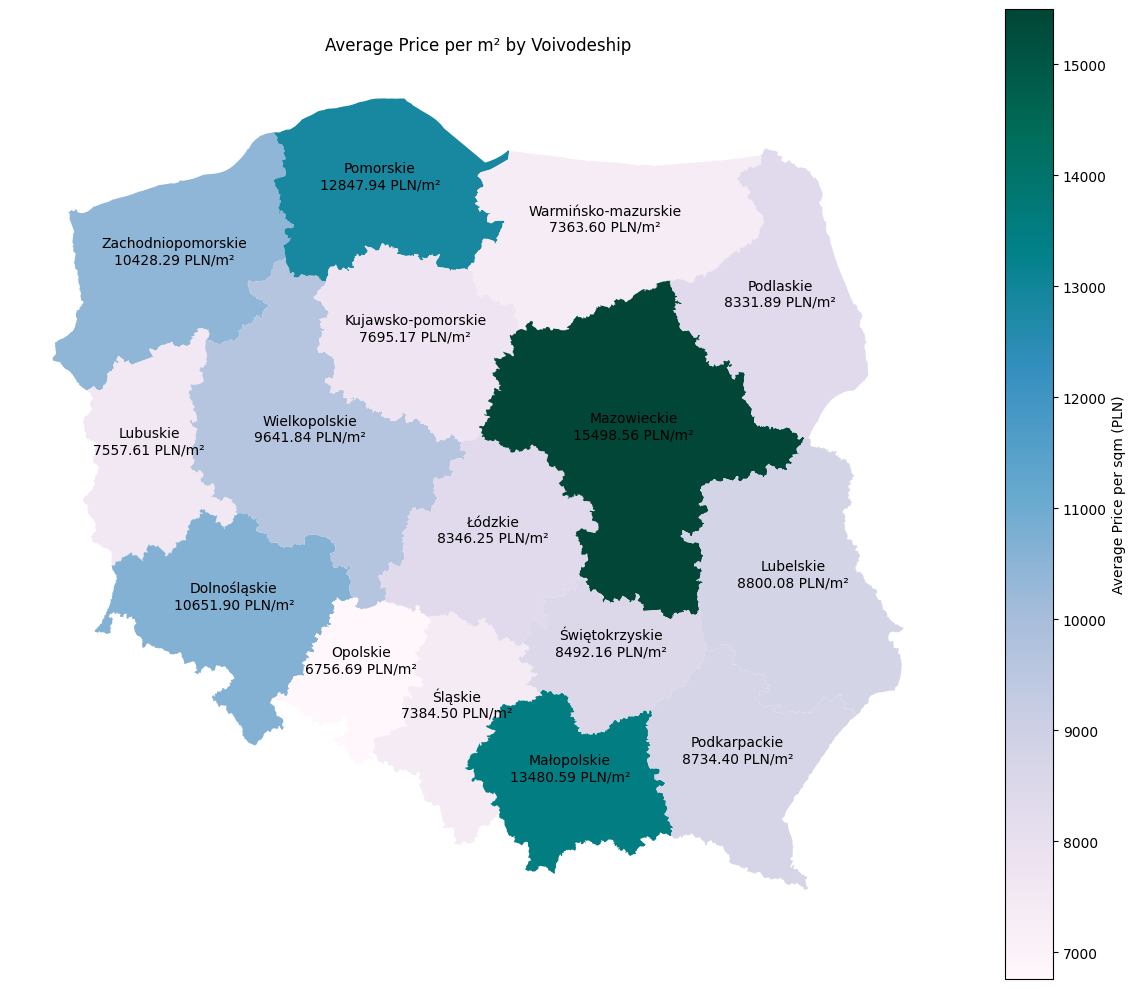

In [22]:
# utworzenie mapy z prezentacją średnich cen za metr kwadratowy w każdym województwie
shapefile_path = 'wojewodztwa.shp'
voivodeship_gdf = gpd.read_file(shapefile_path)
voivodeship_gdf['JPT_NAZWA_'] = voivodeship_gdf['JPT_NAZWA_'].str.lower()
average_price_per_sqm = df_cleaned.groupby('Voivodeship')['Price_per_m2'].mean().reset_index()
average_price_per_sqm['Voivodeship'] = average_price_per_sqm['Voivodeship'].str.lower()
average_price_per_sqm.columns = ['JPT_NAZWA_', 'avg_price_per_sqm']
voivodeship_gdf = voivodeship_gdf.merge(average_price_per_sqm, on='JPT_NAZWA_', how='left')
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
voivodeship_gdf.plot(
    column='avg_price_per_sqm',
    cmap='PuBuGn',
    legend=True,
    legend_kwds={'label': "Average Price per sqm (PLN)"},
    ax=ax
)
for x, y, label, price in zip(
    voivodeship_gdf.geometry.centroid.x,
    voivodeship_gdf.geometry.centroid.y,
    voivodeship_gdf['JPT_NAZWA_'],
    voivodeship_gdf['avg_price_per_sqm']
):
    ax.text(
        x, y, f"{label.capitalize()}\n{price:.2f} PLN/m²",
        fontsize=10, ha='center', color='black'
    )

plt.title('Average Price per m² by Voivodeship')
plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
# zakodowanie danych kategorycznych za pomoca one-hot encoding
df_cleaned = df_cleaned.dropna(subset=['Price'])
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df_cleaned[['Voivodeship', 'Parking_Space', 'Number_of_Rooms']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Voivodeship', 'Parking_Space', 'Number_of_Rooms']))
df_encoded = pd.concat([df_cleaned.drop(columns=['Voivodeship', 'Parking_Space', 'Number_of_Rooms']).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [24]:
df_encoded

,Price,Surface,Price_per_m2,Voivodeship_Kujawsko-pomorskie,Voivodeship_Lubelskie,Voivodeship_Lubuskie,Voivodeship_Mazowieckie,Voivodeship_Małopolskie,Voivodeship_Opolskie,Voivodeship_Podkarpackie,...,Voivodeship_Śląskie,Voivodeship_Świętokrzyskie,Parking_Space_1,Number_of_Rooms_2,Number_of_Rooms_3,Number_of_Rooms_4,Number_of_Rooms_5,Number_of_Rooms_6,Number_of_Rooms_7,Number_of_Rooms_9
0,415000.0,47.00,8829.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2499000.0,105.00,23800.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,649000.0,60.00,10816.67,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2108000.0,78.30,26922.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,450180.0,49.20,9150.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,525000.0,34.00,15441.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2590,829000.0,61.18,13550.18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2591,830000.0,50.00,16600.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2592,699000.0,66.47,10516.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
#podzial danych na testowe - 20% i trenigowe - 80%
X = df_encoded.drop(columns=['Price_per_m2'])
y = df_encoded['Price_per_m2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# stworzenie modelu RandomForest + cross validation + prezentacja wyników
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mse_scores_rf = cross_val_score(rf_model, X, y, scoring='neg_mean_squared_error', cv=5)
r2_scores_rf = cross_val_score(rf_model, X, y, scoring='r2', cv=5)

cross_val_mse = -cross_val_score(rf_model, X, y, scoring='neg_mean_squared_error', cv=5).mean()
cross_val_rmse = np.sqrt(cross_val_mse)
cross_val_r2 = cross_val_score(rf_model, X, y, scoring='r2', cv=5).mean()

print("Mean Squared Error:", mse_rf)
print("R² Score:", r2_rf)
print("Root Mean Squared Error:", rmse_rf)

print("Cross-Validation MSE:", cross_val_mse)
print("Cross-Validation R²:", cross_val_r2)
print("Cross-Validation RMSE:", cross_val_rmse)

Mean Squared Error (MSE): 250563.2088614531
R² Score: 0.9900294117686614
Root Mean Squared Error (RMSE): 500.56289201403365
Cross-Validation MSE: 350843.1119214924
Cross-Validation R²: 0.9865886999584849
Cross-Validation RMSE: 592.3201093340427


In [30]:
fig = px.scatter(
    x=y_test,
    y=y_pred_rf,
    labels={"x": "Actual Prices (PLN)", "y": "Predicted Prices (PLN)"},
    title="Actual vs. Predicted Prices (Random Forest)",
    width=600,
    height=400
)
fig.add_shape(
    type="line",
    x0=y_test.min(),
    y0=y_test.min(),
    x1=y_test.max(),
    y1=y_test.max(),
    line=dict(color="red")
)
fig.show()

In [27]:
# stworzenie modelu regresji liniowej + cross validation + prezentacja wyników
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mse_scores_linear = cross_val_score(linear_model, X, y, scoring='neg_mean_squared_error', cv=5)
r2_scores_linear = cross_val_score(linear_model, X, y, scoring='r2', cv=5)

cross_val_mse = -cross_val_score(rf_model, X, y, scoring='neg_mean_squared_error', cv=5).mean()
cross_val_rmse = np.sqrt(cross_val_mse)
cross_val_r2 = cross_val_score(rf_model, X, y, scoring='r2', cv=5).mean()

print("Mean Squared Error:", mse_linear)
print("R² Score:", r2_linear)
print("Root Mean Squared Error:", rmse_linear)

print("Cross-Validation MSE:", cross_val_mse)
print("Cross-Validation R²:", cross_val_r2)
print("Cross-Validation RMSE:", cross_val_rmse)

Mean Squared Error : 2988411.475168969
R² Score: 0.8810830192504745
Root Mean Squared Error: 1728.702251739428
Cross-Validation MSE: 350843.1119214924
Cross-Validation R²: 0.9865886999584849
Cross-Validation RMSE: 592.3201093340427


In [32]:
fig = px.scatter(
    x=y_test,
    y=y_pred_linear,
    labels={"x": "Actual Prices (PLN)", "y": "Predicted Prices per m² (PLN)"},
    title="Actual vs. Predicted Prices per m² (Linear Regression)",
    width=600,
    height=400,
    color_discrete_sequence=["green"]
)

# Add a reference line (perfect prediction)
fig.add_shape(
    type="line",
    x0=y_test.min(),
    y0=y_test.min(),
    x1=y_test.max(),
    y1=y_test.max(),
    line=dict(color="red")
)
# Show the interactive plot
fig.show()

In [33]:
#wykres porównawczy random forest i regresji liniowej
fig = make_subplots(rows=1, cols=2, subplot_titles=(
    "Random Forest: Actual vs Predicted Price per m²", 
    "Linear Regression: Actual vs Predicted Price per m²"))
rf_predictions = rf_model.predict(X_test)
df_rf = pd.DataFrame({'Actual': y_test, 'Predicted': rf_predictions})
df_linear = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_linear})

fig.add_trace(
    go.Scatter(x=df_rf['Actual'], y=df_rf['Predicted'], mode='markers',
               marker=dict(color='blue', opacity=0.6), name='Predicted (RF)'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()],
               mode='lines', line=dict(color='red', dash='dash'), name='Ideal'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_linear['Actual'], y=df_linear['Predicted'], mode='markers',
               marker=dict(color='green', opacity=0.6), name='Predicted (LR)'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()],
               mode='lines', line=dict(color='red', dash='dash'), name='Ideal'),
    row=1, col=2
)

fig.update_layout(
    title_text="Model Predictions vs Actual Price per m²",
    title_x=0.5,
    height=600, width=1500,
    showlegend=True
)
fig.update_xaxes(title_text="Actual Price per m²", row=1, col=1)
fig.update_yaxes(title_text="Predicted Price per m²", row=1, col=1)
fig.update_xaxes(title_text="Actual Price per m²", row=1, col=2)
fig.update_yaxes(title_text="Predicted Price per m²", row=1, col=2)

fig.show()
